In [ ]:
from chartpeer.loader import load
from chartpeer.analysis import *

# load bitcoin daily data (1440 minutes = 24h interval)
data = load.closedFromFile('C:\\Users\\weezl\\Desktop\\B0-B\\Scripting\\chartPeer-trading\\ChartPeer-SDK\\data\\XBTUSD_1440.csv')

# get 365 recent days of bitcoin closed prices
fade = 850
yearDataset = data[-365-fade:-fade]

# split the the year in 11 months and one additional "continuation" month
# this helps to compare the prediction to real data
testSet = yearDataset[:335]
continuation = yearDataset[335:365]

In [ ]:
# plot the result for comparison
# plot the result for comparison
plot.chart(testSet, predictionSets = {
    'Real Continuation': continuation,
})

In [ ]:
import numpy as np
import chartpeer.extrapolate as extrapolate

def gbm (data, length):

    '''
    Simulation of geometric brownian motion path.
    Drift mu and volatility sigma are sampled from the data.
    The standard error deviation on both parameters is 1/sqrt(N)
    i.e. 100 data points yield 1/10 uncertainty.
    '''

    mu = statistics.drift(data)
    sigma = statistics.volatility(data)

    S = [data[-1]]
    for t in range(length):
        delta_S = S[-1] * (mu + sigma * np.random.normal(0,1))
        S_new = S[-1] + delta_S
        S.append(S_new)
    
    return np.array(S[1:])


In [ ]:
plot.chart(testSet[-100:], predictionSets = {
    'Real Continuation': continuation,
    'Generic GBM': gbm(testSet, 30),
    'Generic Intrinsic GBM': extrapolate.gbm(testSet, 30, sampling='intrinsic')
})

# Model the VIX

Try to extract the timeresolved volatility from the underlying data

In [ ]:
def vix (dataset, N):

    '''
    Volatility Index.
    Returns time-resolved volatility with window meaning N. 
    Meaning is obtained from simple moving average.
    '''

    vol = []
    for i in range(N, len(dataset)):
        slicedSet = np.array(dataset[i-N:i])
        v = statistics.volatility(slicedSet)
        vol.append(v)
    
    return np.array(vol)

v = vix(yearDataset, 14)

# split volatility array into input and target array
v_input = v[:-30]
v_target = v[-30:]

from chartpeer.extrapolate import hw
from chartpeer.extrapolate import hw_fit

# fit smoothing parameters by providing demanded extrapolation size and period 
# this can take a couple of seconds.
fit = hw_fit(v_input, 30, periodInIntervals=7, fitRange=[0,1])

# inject fit into new prediction
prediction_auto = hw(v_input, 30, *fit, periodInIntervals=30)

plot.chart(v_input, name='vix', predictionSets={
    'vix continuation': v_target,
    'HW prediction of VIX': prediction_auto
})

In [ ]:
# second idea is to model the vix with lstm

from chartpeer.extrapolate import lstm

predictor = lstm(sequence_length=60, feature_length=30, epochs=10, batch_size=1)

vix_prediction = predictor.predict(v_input)['prediction']

In [ ]:
plot.chart(v_input, name='vix', predictionSets={
    'vix continuation': v_target,
    'LSTM prediction of VIX': vix_prediction
})

LSTM for VIX prediction seems most suitable as LSTM is able to detect even slightest patterns and converges almost always - the higher the mean window, the better the convergence will be due to the smoothness. In general better results are achieved with smaller batch size (ideally single batch i.e. 1) and larger epochs. Good results were observed with 20 epochs and batch_size=1 for a 60->30 length prediction.

# Model the Drift with LSTM

In [ ]:
# analgogously resolve the drift over time

def driftHistory (dataset, N):
    d = []
    for i in range(N, len(dataset)):
        drf = statistics.drift(np.array(dataset[i-N:i]))
        d.append(drf)
    return np.array(d)

d = driftHistory(yearDataset, 10)
d_input = d[:-30]
d_target = d[-30:]

#predictor = lstm(sequence_length=60, feature_length=30, epochs=30, batch_size=10)
drift_prediction = predictor.predict(d_input)['prediction']

plot.chart(d_input, name='Drift', predictionSets={
    'Drift continuation': d_target,
    'LSTM prediction of Drift': drift_prediction
})

# Extended GBM

An obvious flaw of the geometric brownian motion SDE is that the drift and volatility are assumed to be constant. For a better fit we will assume the parameters $\mu$ and $\sigma$ to evolve according to the LSTM fits.

In [ ]:
def gbm_ext (data, length):

    '''
    Simulation of geometric brownian motion path.
    Drift mu and volatility sigma vary over time are taken from LSTM fit.
    The differential equation is fixed accordingly.
    '''

    mu = drift_prediction
    sigma = vix_prediction

    S = [data[-1]]
    for t in range(length):
        delta_S = S[-1] * (mu[t] + sigma[t] * np.random.normal(0,1))
        S_new = S[-1] + delta_S
        S.append(S_new)
    
    return np.array(S[1:])

In [ ]:
plot.chart(testSet[-100:], predictionSets = {
    'Real Continuation': continuation,
    'Extended GBM': gbm_ext(testSet, 30)
})

In [ ]:
# try to plot a meaned set of MC generations
generations = 30
g = gbm_ext(testSet, 30)
for i in range(generations-1):
    g = g + gbm_ext(testSet, 30)

g = g / generations

# define limits by the vix
dev = 1
upper_lim = []
lower_lim = []
for i in range(len(vix_prediction)):
    upper_lim.append(g[i]*(1+dev*vix_prediction[i]*np.sqrt(i)))
    lower_lim.append(g[i]*(1-dev*vix_prediction[i]*np.sqrt(i)))
upper_lim = np.array(upper_lim)
lower_lim = np.array(lower_lim)

plot.chart(testSet[-100:], predictionSets = {
    'Real Continuation': continuation,
    'Mean Extended GBM': g,
    'Upper Limit': upper_lim,
    'Lower Limit': lower_lim
})

# New Models for Geometric Brownian SDE

# LSTM GBM

Most extensions of the GBM SDE are based on a stochastic volatility model, where the volatility is not constant but instead follows a geometric brownian itself. To focus on the general ansatz the SDE can be extended to 

\begin{align*}
dS_t = \mu S_t + \nu_t S_t dW_t
\end{align*}

where $\nu_t$ denotes the time-dependent volatility. At this level of generalization the following thesis is raised, whether the drift $\mu$ can vary as well. Indeed such approaches exist - within the reasearch field of <strong>stochastic volatility</strong>. The time dependence of GBM parameters relies on the pragmatic idea to apply the same modelling on generator level, where the combination of $\mu$ and $\sigma$ acts as the generating moment $\frac{d S}{d t}$ and can be calculated with Itô's general solution.

Assuming that the vectors $\nu(t) \equiv \nu_t$ and $\mu(t)$ could be approximated accurately enough (at least in the mean), to increase the sampling efficiency due to better price direction sampling and also would make methods like selection of specific path generations (which suite the conjectured continuation from other methods e.g. by discarding generations which do not respect linear regression) obsolete. Also the time-resolved volatility allows to model uncertainty regimes over time.

Further the model can also be extended by a self-study ansatz "intrinsic geometric brownian motion", which exploits the method of sampling from an intrinsic log return distribution accounted from data instead of sampling from a standard normal. When the expected mean drift $\mu=\left\langle log \left (  R \right ) \right\rangle_a$ is subtracted from the distribution and devided by the meaned volatility $\sigma$ then the obtained distribution should be "similar" to a standard normal distribution $\sim \mathcal{N}(0,1)$ and thus an unbiased estimator. The assumption that the mean is zero arises from the central limit theorem, and is actually biased by the standard error $1/\sqrt{n}$, so for a large enough data sample the bias should converge sufficiently to zero. The newly derived distribution yields the "sampled wiener distribution" which can be exploited for better (biased to the data, and less generic) sampling of randomness. This will allow to model specific (data-suited) return patterns for more seamless generations, since specific wiener increments which were not obsereved in the input data are prohibited for sampling by this method, whereas a gaussian simply assumes a smoothly interpolated non-zero value and underestimates edge-tail events, which are non-negligible and can be proven from the data. Increments obtained (sampled) from the sampled wiener distribution are denoted by $d\tilde{W}_t$. The newly improved differential equation can be written as


\begin{align*}
dS_t = \mu_t S_t + \nu_t S_t d\tilde{W}_t
\end{align*}

The parameters can be estimated with a LSTM RNN prediction. With sufficient smoothing for a sufficiecnt mean approximation for $\mu, \sigma$ the LSTM with $\sim 20$ epochs of single-batch training converges in it's standard mean error to sufficiently good fits - the method is often helpful to estimate the approximated evolutions which should improve the determinacy of the SDE samples. Thus, rather than a completely generic MC generation, based on constant parameters and a standard normal wiener process, the improced SDE will be biased in the most expected direction and the volatility will obey the intrisic distribution. For small enough time steps (prediction data points). Since the LSTM is uniquely fitted to the problem at hand, at these epoch sizes overfitting the model to the finite input will result in a more conservative prediction and focuses to predict based to replicate the test data. Otherwise for small epoch sizes the prediction will yield more generic predictions i.e. less biased by the input pattern. 

In [ ]:
from chartpeer.extrapolate import lstm, lstm_gbm

output = lstm_gbm(testSet, 30, epochs=(20,10), smoothing=14)

plot.chart(testSet[-100:], predictionSets = {
    'Real Continuation': continuation,
    'Mean Extended GBM': output['mean'],
    'Upper Limit': output['upper'],
    'Lower Limit': output['lower']
})

## Application to Live Data

In [ ]:
# make a real time prediction
from chartpeer.loader import krakenApi, load
from chartpeer.extrapolate import lstm_gbm

# request recent 720 candles from kraken and slice to last 365 days
ohlc = krakenApi.ohlc('BTC', 60)
closed = load.closedFromOhlc(ohlc)[-365:]

output = lstm_gbm(closed, 30, epochs=(20,10), smoothing=14)


In [ ]:
plot.chart(closed, name='BTC Live Data', predictionSets = {
    'Mean Extended GBM': output['mean'],
    'Upper Limit': output['upper'],
    'Lower Limit': output['lower']
})

## Downsides

Although the predictions are often accurate, depending on the fit, small variations are still making the prediction random. This is caused by mutually distinct trainings and MC simulations. Due to the large epoch size and smallest batch size, the fit can take several minutes of time.

# Model GBM Parameters with FFT

Not all devices support LSTM training, especially due to memory limitations on micro controllers. However, the improved SDE should not be dismissed, instead the pursuit of faster and more deteministic pattern-seeking- or evolution algorithms motivates to test other methods for the GBM parameter forecasting.

In [1]:
# make a real time prediction
from chartpeer.loader import krakenApi, load
from chartpeer.extrapolate import lstm_gbm
from chartpeer.analysis import *

# request recent 720 candles from kraken and slice to last 365 days
ohlc = krakenApi.ohlc('BTC', 60)
closed = load.closedFromOhlc(ohlc)[-365:]

# split the closed set into input and target, input will be used for training
output_length = 14
input = closed[:-output_length]
target = closed[-output_length:]

data = input

First test if the reusing of the same model (model for $\nu_t$ used for further training of $\mu_t$) has impact on the prediction quality.

In [ ]:
output = lstm_gbm(input, feature_length=output_length, smoothing=5, reuse_model=True)
plot.chart(input, name='BTC Live Data', predictionSets = {
    'Mean Extended GBM': output['mean'],
    'Real Continuation': target,
    'Upper Limit': output['upper'],
    'Lower Limit': output['lower']
})
plot.chart(input[-100:], name='BTC Live Data', predictionSets = {
    'Mean Extended GBM': output['mean'],
    'Real Continuation': target,
    'Upper Limit': output['upper'],
    'Lower Limit': output['lower']
})

In [ ]:
# repeat with seperated predictor models, for this we increase the fit epochs for the second model to the same size of the first
output = lstm_gbm(input, feature_length=output_length, epochs=(20,20), reuse_model=False)
plot.chart(input, name='BTC Live Data', predictionSets = {
    'Mean Extended GBM': output['mean'],
    'Real Continuation': target,
    'Upper Limit': output['upper'],
    'Lower Limit': output['lower']
})
plot.chart(input[-100:], name='BTC Live Data', predictionSets = {
    'Mean Extended GBM': output['mean'],
    'Real Continuation': target,
    'Upper Limit': output['upper'],
    'Lower Limit': output['lower']
})

## Disamble $\nu$ and $\mu$ in Fourier Space

In [2]:
import numpy as np

def vix (dataset, N):

    '''
    Volatility Index.
    Returns time-resolved volatility with window meaning N. 
    Meaning is obtained from simple moving average.
    '''

    vol = []
    for i in range(N, len(dataset)):
        slicedSet = np.array(dataset[i-N:i])
        v = statistics.volatility(slicedSet)
        vol.append(v)
    
    return np.array(vol)

nu = vix(input, 5)

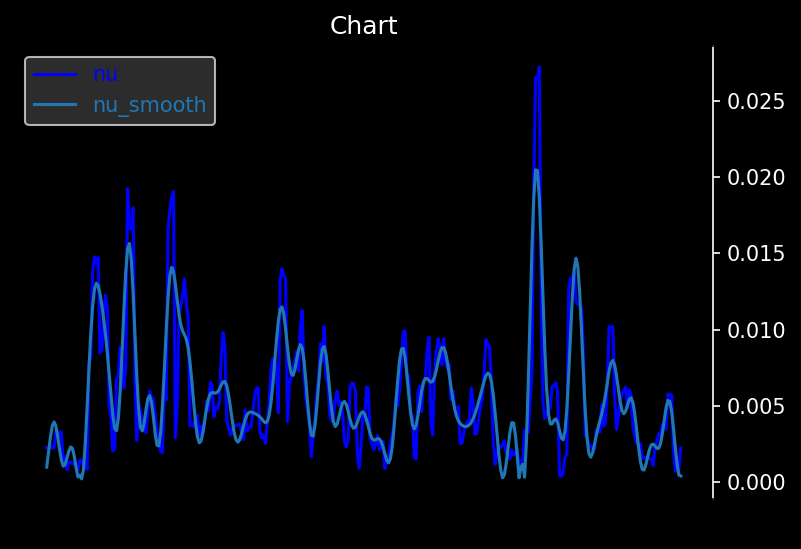

In [6]:
def fft_smoothing (F, smoothing=0):

    F = np.fft.fft(nu)

    # smooth
    smooth_cut = int(F.shape[0]*(1-smoothing))
    for i in range(smooth_cut, F.shape[0]-smooth_cut):
        F[i] = 0

    return np.fft.ifft(F)

# take the absolute value of the fft to eliminate complex part
nu_smooth = np.abs(fft_smoothing(nu, 0.90))

plot.chart(nu, 'nu', overlays={'nu_smooth': nu_smooth})
# plot.chart(nu_smooth, 'nu_smooth')

In [7]:
nu_smooth

array([0.0009968 , 0.00194146, 0.00294254, 0.00368573, 0.00395068,
       0.00368235, 0.00300165, 0.00215512, 0.00142733, 0.00106059,
       0.00115513, 0.00156312, 0.00203338, 0.00231394, 0.0022196 ,
       0.00171205, 0.00094319, 0.00034506, 0.00046969, 0.00022796,
       0.00081936, 0.00261688, 0.00495272, 0.0074661 , 0.00976967,
       0.01155113, 0.01264418, 0.01304725, 0.01288793, 0.0123498 ,
       0.01159189, 0.01069523, 0.00966035, 0.00845458, 0.0070828 ,
       0.00564569, 0.00435666, 0.00350506, 0.00338477, 0.00421349,
       0.0060111 , 0.00853072, 0.01130588, 0.01375532, 0.01532632,
       0.01564428, 0.01462191, 0.01249106, 0.00974382, 0.00699819,
       0.00482757, 0.00359958, 0.00336681, 0.00388647, 0.00474102,
       0.00546125, 0.00567767, 0.0052479 , 0.00430346, 0.00320508,
       0.00242581, 0.00238304, 0.00327011, 0.00503575, 0.00739956,
       0.00990895, 0.01207627, 0.01352284, 0.01407941, 0.01381487,
       0.01298814, 0.01194365, 0.01099011, 0.01030686, 0.00990

Epoch 1/10
258/258 [==============================] - 5s 14ms/step - loss: 0.0328
Epoch 2/10
258/258 [==============================] - 3s 13ms/step - loss: 0.0266
Epoch 3/10
258/258 [==============================] - 3s 13ms/step - loss: 0.0257
Epoch 4/10
258/258 [==============================] - 3s 13ms/step - loss: 0.0242
Epoch 5/10
258/258 [==============================] - 3s 14ms/step - loss: 0.0226
Epoch 6/10
258/258 [==============================] - 3s 13ms/step - loss: 0.0218
Epoch 7/10
258/258 [==============================] - 3s 14ms/step - loss: 0.0203
Epoch 8/10
258/258 [==============================] - 3s 13ms/step - loss: 0.0193
Epoch 9/10
258/258 [==============================] - 3s 13ms/step - loss: 0.0175
Epoch 10/10
1/1 [==============================] - 0s 486ms/step


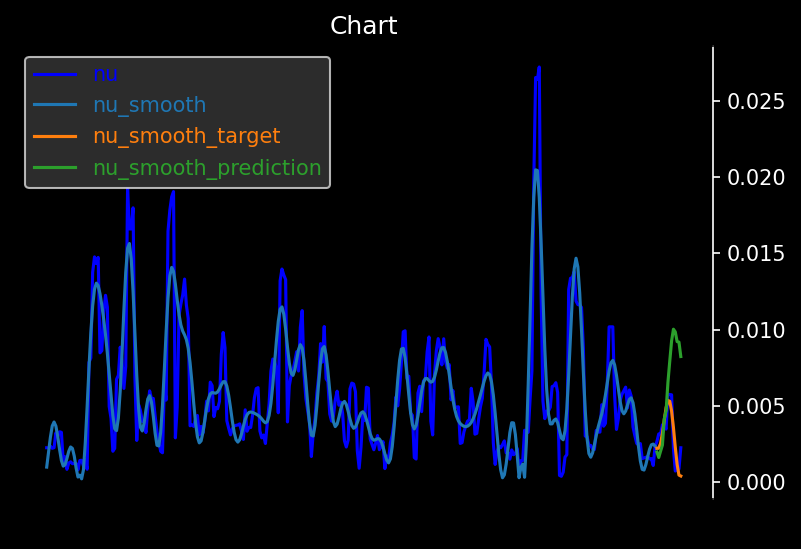

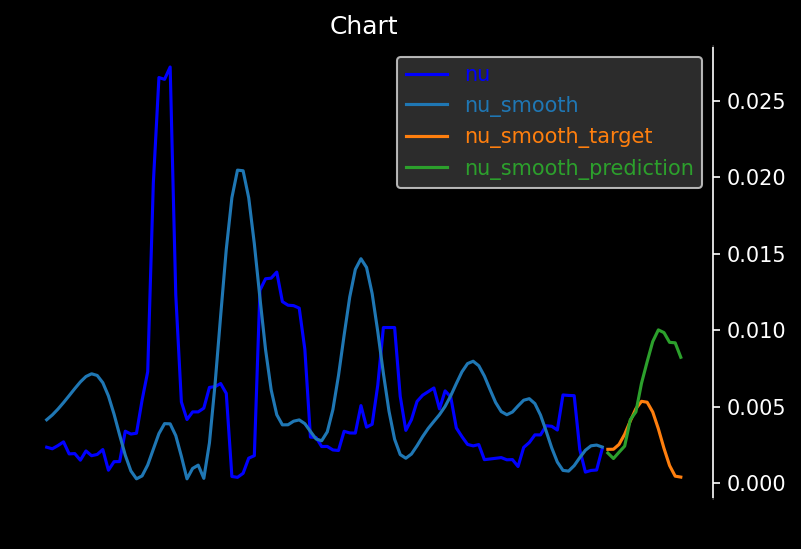

In [11]:
# try to predict from nu_smooth
from chartpeer.extrapolate import lstm


feature_length = 14
nu_smooth_input = nu_smooth[:-feature_length]
nu_smooth_target = nu_smooth[-feature_length:]

predictor = lstm(sequence_length=60, feature_length=feature_length, epochs=10, batch_size=1)
result = predictor.predict(nu_smooth_input)
prediction = result['prediction']

plot.chart(nu, 'nu', overlays={
    'nu_smooth': nu_smooth_input
}, predictionSets={
    'nu_smooth_target': nu_smooth_target,
    'nu_smooth_prediction': prediction,
    'nu_smooth_target': nu_smooth_target
})

plot.chart(nu[-100:], 'nu', overlays={
    'nu_smooth': nu_smooth_input[-100:]
}, predictionSets={
    'nu_smooth_target': nu_smooth_target,
    'nu_smooth_prediction': prediction,
    'nu_smooth_target': nu_smooth_target
})
